In [1]:
#web source: https://www.kaggle.com/datasets/anmolbajpai/planetary-systems-nasa-exoplanet-archive/data
#ORIGINAL SOURCE: NASA's Exoplanet Archive

![](https://www.mdscc.nasa.gov/wp-content/uploads/2019/08/keplerbeautyshot.jpg)

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/planetary-systems-nasa-exoplanet-archive/planetary_systems.csv


In [4]:
df=pd.read_csv('/kaggle/input/planetary-systems-nasa-exoplanet-archive/planetary_systems.csv')

# 1.1- COLUMNS DESCRIPTION

# 1.2- INTERESTING FEATURES TO HAVE A LOOK AT EXOPLANETS HABITABILITY

#     LATER ON WE WILL FIND OUT THAT WE HAVE A LOT OF MISSING VALUES IN THE EXOPLANETS INFO. PERHAPS IT WOULD BE MORE INTERESTING TO CREATE A MODEL EVALUATING POTENTIAL LIFE SUPPORTING STARS SINCE WE HAVE MUCH MORE DATA

#  EXPLORING DATA

In [5]:
df.shape  #SHAPE OF DF: (33972, 92)

(33972, 92)

In [6]:
#CHECKING NULL VALUES
columns_list=[e for e in df.columns]
missing_values_columns=[]  
for co in columns_list:
    if df[co].isnull().any()==True:
        missing_values_columns.append(co)
len(missing_values_columns)

73

In [7]:
#COLUMN NAMES WITH NO MISSING VALUES AT ALL
non_missing=[]
for el in columns_list:
    if el not in missing_values_columns:
        non_missing.append(el)
len(non_missing)

19

In [8]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
len(categorical_columns), len(numerical_columns)

(16, 76)

In [9]:
#WHAT IF WE DROP NA?
df.dropna().shape  #ONLY 58 SAMPLES DO NOT HAVE MISSING VALUES

(58, 92)

In [10]:
#WHAT IF WE DROP DUPLICATES?
df.shape[0]-df.drop_duplicates().shape[0] #THERE ARE 53 DUPLICATES

53

In [11]:
df.drop_duplicates(inplace=True)

# SELECTING SOME COLUMNS THAT ARE CRUCIAL FOR THE EXOPLANET TO BE HABITABLE

In [12]:
#TO IDENTIFY EXOPLANET, SYSTEM AND STAR
IDENTIFICATION_columns=["pl_name", "hostname", "default_flag", "sy_snum", "sy_pnum"]
#RELATED TO THE RELIABILITY 
DISCOVERY_columns=["discoverymethod", "disc_facility"]
#IMPORTANT PARAMETERS OF THE PLANETS TO FIGURE OUT THEIR HABITABILITY
PARAMETERS_columns=["pl_orbper","pl_orbsmax","pl_rade", "pl_bmasse", "pl_orbeccen", "pl_insol", "pl_eqt"]
#STAR FEATURES MAY HELP IDENTIFY HABITABILITY
STELLAR_columns=["st_teff", "st_mass", "st_rad", "st_met"]
#STAR DATA THAT MAY REINFORCE THE PREVIOUS FEATURES
PHOTOMETRY_columns=["sy_dist", "sy_vmag", "sy_kmag"]

list_types_features=[IDENTIFICATION_columns, DISCOVERY_columns, PARAMETERS_columns,STELLAR_columns,PHOTOMETRY_columns]

In [13]:
#GETTING ALL THE COLUMNS TOGETHER IN A LIST
column_names=[i for e in list_types_features for i in e]

# NULLS OF OUR CHOSEN COLUMNS

In [14]:
def show_nulls(columns, df):
    null_dict = {'Column': [], 'Has Nulls': [], 'Total Columns': []}
    
    for e in columns:
        has_nulls = df[e].isnull().any()
        total = df[e].isnull().sum()
        
        null_dict['Column'].append(e)
        null_dict['Has Nulls'].append(has_nulls)
        null_dict['Total Columns'].append(total)
    
    result_df = pd.DataFrame(null_dict)
    return result_df

result_df1 = show_nulls(df.columns, df)


# LET'S SEE THE NULLS IN THE CHOSEN COLUMNS FOR PLANETS

In [15]:
def show_nulls(columns, df):
    null_dict = {'Column': [], 'Has Nulls': [], 'Total Columns': []}
    
    for e in columns:
        has_nulls = df[e].isnull().any()
        total = df[e].isnull().sum()
        
        null_dict['Column'].append(e)
        null_dict['Has Nulls'].append(has_nulls)
        null_dict['Total Columns'].append(total)
    
    result_df = pd.DataFrame(null_dict)
    return result_df

result_df = show_nulls(column_names, df)


In [16]:
df_planets_clean=df.copy()
df_planets_clean[column_names].dropna(inplace=True)

# THERE IS A LOT OF INFO MISSING, PARTICULARLY ABOUT EXOPLANETS

# WE SEE WE DO NOT HAVE CRUCIAL INFO ON A HIGH PERCENTAGE OF THEM. IMPUTING THEM WITH THE MEAN OR FILLING THEM IN ANY OTHER WAY WOULD BE NON-SENSE SINCE IT WOULDN'T BE ACCURATE

# STAR RELEVANT FEATURES

In [17]:
star_columns=["st_teff", "st_met", "st_mass", "sy_dist", "st_rad", "sy_vmag", "sy_kmag", "sy_gaiamag"]
star_nulls = show_nulls(star_columns, df)
star_nulls

,Column,Has Nulls,Total Columns
0,st_teff,True,2466
1,st_met,True,12569
2,st_mass,True,5286
3,sy_dist,True,788
4,st_rad,True,2349
5,sy_vmag,True,505
6,sy_kmag,True,524
7,sy_gaiamag,True,804


In [18]:
#CHECK IF THESE COLUMNS ARE NUMERIC
df[star_columns].select_dtypes(include=['int64', 'float64']).head()

,st_teff,st_met,st_mass,sy_dist,st_rad,sy_vmag,sy_kmag,sy_gaiamag
0,4742.0,-0.35,2.70,93.1846,19.00,4.72307,2.282,4.44038
1,NaN,NaN,2.60,93.1846,NaN,4.72307,2.282,4.44038
2,4340.0,0.04,1.80,125.3210,24.08,5.01300,1.939,4.56216
3,NaN,NaN,1.70,125.3210,NaN,5.01300,1.939,4.56216
4,4213.0,-0.02,2.78,125.3210,29.79,5.01300,1.939,4.56216


# WE FILLED ALL NULL VALUES

In [19]:
df_star = df.copy()
df_star[star_columns] = df_star[star_columns].fillna(df_star[star_columns].mean())

# LIFE SUPPORTING STAR CRITERIA

In [20]:
df_star.head()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,14/05/14,2008-01,14/05/14
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,23/07/14,2011-08,23/07/14
2,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,25/04/18,2009-10,14/05/14
3,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,25/04/18,2011-08,23/07/14
4,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,04/09/18,2017-03,06/09/18


In [21]:
df_star.shape

(33919, 92)

# VISUALIZATION

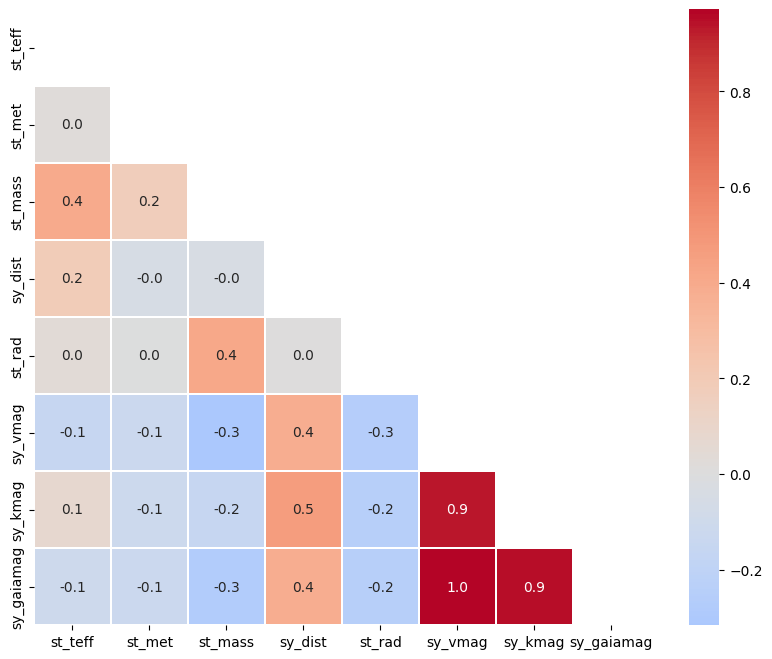

In [22]:
matrix = df_star[star_columns].corr()

mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(10, 8))

sns.heatmap(matrix,
            center=0, 
            fmt=".1f", 
            mask=mask, 
            square=True, 
            linewidth=0.3, 
            annot=True, 
            cmap='coolwarm')

plt.show()

In [23]:
#These features are highly correlated: sy_vmag and sy_gaiamag(brightness), sy_kmag(temperature).
#They may be helpful to indicate temperature, color, distance, radiation... of the star.

# PROJECT IDEA TO BE CONTINUED:
# USING THE CRITERIA ABOVE (SIMILAR TO THE SUN) TO CREATE A MODEL THAT CLASSIFIES THESE STARS IN POTENTIAL LIFE-SUPPORTING STARS